# 9.523 Project


First need to run this to install torch and torchvison


In [1]:
# Initialize notebook.
!pip install -qU plotly torch torchvision 
!pip install -qU Pillow==4.1.1
!pip install -qU pretrainedmodels

tcmalloc: large alloc 1073750016 bytes == 0x58826000 @  0x7f508a4fa2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


Run this to mount google drive to save results to my drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

All of the libraries needed

In [0]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models

import math
from scipy.ndimage.filters import gaussian_filter

import copy
from PIL import Image
import matplotlib.cm as mpl_color_map

from torch.autograd import Variable
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm 

import pretrainedmodels

cuda = torch.device('cuda')  

In [3]:
model_name = 'nasnetalarge'
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet').cuda()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth" to /root/.torch/models/nasnetalarge-a1897284.pth
100%|██████████| 356056626/356056626 [00:18<00:00, 18911085.07it/s]


Helper functions for visualiztion program

Main code for visualization

In [0]:
def save_image(im, path):
    """
        Saves a numpy matrix of shape D(1 or 3) x W x H as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, np.ndarray):
        if len(im.shape) == 2:
            im = np.expand_dims(im, axis=0)
        if im.shape[0] == 1:
            # Converting an image with depth = 1 to depth = 3, repeating the same values
            # For some reason PIL complains when I want to save channel image as jpg without
            # additional format in the .save()
            im = np.repeat(im, 3, axis=0)
            # Convert to values to range 1-255 and W,H, D
        if im.shape[0] == 3:
            im = im.transpose(1, 2, 0) * 255
        im = Image.fromarray(im.astype(np.uint8))
    im.save(path)


def preprocess_image(pil_im):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float().cuda()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.5, -0.5, -0.5]
    reverse_std = [1/0.5, 1/0.5, 1/0.5]
    recreated_im = copy.copy(im_as_var.cpu().data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [0]:
class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_filter, decay, blur_radius, blur_every):
        self.model = model
        self.model.eval()
        self.selected_filter = selected_filter
        self.decay = decay
        self.blur_radius = blur_radius
        self.blur_every = blur_every
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(150, 180, (331, 331, 3)))
    
    def limited_forward(self, input):
        x_conv0 = self.model.conv0(input)
        x_stem_0 = self.model.cell_stem_0(x_conv0)
        x_stem_1 = self.model.cell_stem_1(x_conv0, x_stem_0)

        x_cell_0 = self.model.cell_0(x_stem_1, x_stem_0)
#         x_cell_1 = self.model.cell_1(x_cell_0, x_stem_1)
#         x_cell_2 = self.model.cell_2(x_cell_1, x_cell_0)
#         x_cell_3 = self.model.cell_3(x_cell_2, x_cell_1)
#         x_cell_4 = self.model.cell_4(x_cell_3, x_cell_2)
#         x_cell_5 = self.model.cell_5(x_cell_4, x_cell_3)

#         x_reduction_cell_0 = self.model.reduction_cell_0(x_cell_5, x_cell_4)

#         x_cell_6 = self.model.cell_6(x_reduction_cell_0, x_cell_4)
#         x_cell_7 = self.model.cell_7(x_cell_6, x_reduction_cell_0)
#         x_cell_8 = self.model.cell_8(x_cell_7, x_cell_6)
#         x_cell_9 = self.model.cell_9(x_cell_8, x_cell_7)
#         x_cell_10 = self.model.cell_10(x_cell_9, x_cell_8)
#         x_cell_11 = self.model.cell_11(x_cell_10, x_cell_9)

#         x_reduction_cell_1 = self.model.reduction_cell_1(x_cell_11, x_cell_10)

#         x_cell_12 = self.model.cell_12(x_reduction_cell_1, x_cell_10)
#         x_cell_13 = self.model.cell_13(x_cell_12, x_reduction_cell_1)
#         x_cell_14 = self.model.cell_14(x_cell_13, x_cell_12)
#         x_cell_15 = self.model.cell_15(x_cell_14, x_cell_13)
#         x_cell_16 = self.model.cell_16(x_cell_15, x_cell_14)
#         x_cell_17 = self.model.cell_17(x_cell_16, x_cell_15)
        return x_cell_0

    def visualise_layer(self, folder_name, remove_colors, rc = None):
        a = np.uint8(np.random.uniform(100, 150, (331, 331)))
        self.created_image = np.zeros((331,331,3), dtype = np.uint8)
        self.created_image[:,:,0] = a
        self.created_image[:,:,1] = a
        self.created_image[:,:,2] = a
        # Process image and return variable
        self.processed_image = preprocess_image(self.created_image)

        # Define optimizer for the image
        optimizer = Adam([self.processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 101):
            optimizer.zero_grad()
            
            with torch.no_grad():
                for color in remove_colors:
                    self.processed_image[:,color,:,:] = 0
                    
#             # Assign create image to a variable to move forward in the model
#                 self.processed_image[:,0] = self.processed_image.mean(dim = 1)
#                 self.processed_image[:,1] = self.processed_image.mean(dim = 1)
#                 self.processed_image[:,2] = self.processed_image.mean(dim = 1)
            x = self.processed_image
            x = self.limited_forward(x)
                    
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            if rc == None:
                loss = -torch.mean(x[0, self.selected_filter])
            else:
                loss = -torch.mean(x[0, self.selected_filter, rc[0]-1:rc[0]+2, rc[1]-1:rc[1]+2])

            # Backward
            loss.backward()

            # Update image
            optimizer.step()
            
            # Recreate image
            with torch.no_grad():
#                 print(self.processed_image.type()
                self.processed_image *= (1 - self.decay)
    
                mean = [0.5, 0.5, 0.5]
                for color in remove_colors:
                    self.processed_image[:,color,:,:] = -mean[color]
                        
                if self.blur_every is not 0 and self.blur_radius > 0:
                    if i % self.blur_every == 0:
                        for channel in range(3):
                            cimg = gaussian_filter(self.processed_image[:,channel,:,:].cpu().detach().numpy(), self.blur_radius)
                            self.processed_image[:,channel,:,:] = torch.tensor(cimg).cuda()
            # Save image
            if i % 100 == 0:
                self.created_image = recreate_image(self.processed_image)
                print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.cpu().data.numpy()))
                im_path = '/content/gdrive/My Drive/generated/final/' + folder_name + \
                    '_f' + str(self.selected_filter) + '.jpg'
                save_image(self.created_image, im_path)
#                 plt.imshow(self.created_image)
                return -loss.item()
              
    def get_activations(self, image, filter):
        self.processed_image = preprocess_image(image)
        
        with torch.no_grad():
            x = self.processed_image
            x = self.limited_forward(x)

        return x[0,filter,:,:] 
        

In [0]:
decay = 0.0001
blur_radius = 1.
blur_every = 5
filter_pos = 444
layer_vis = CNNLayerVisualization(model, filter_pos, decay, blur_radius, blur_every)

In [539]:
rc = (21,19)
rc = None
plt.rcParams['figure.figsize'] = [10, 5]
colors_to_remove = []
a = layer_vis.visualise_layer("all", colors_to_remove, rc)
colors_to_remove = [1,2]
a = layer_vis.visualise_layer("red", colors_to_remove, rc)
colors_to_remove = [0,2]
a = layer_vis.visualise_layer("green", colors_to_remove, rc)
colors_to_remove = [0,1]
a = layer_vis.visualise_layer("blue", colors_to_remove, rc)

Iteration: 100 Loss: -5.78
Iteration: 100 Loss: -4.51
Iteration: 100 Loss: -3.99
Iteration: 100 Loss: -3.73


In [552]:
rc = (21,19)
# rc = None
plt.rcParams['figure.figsize'] = [10, 5]
colors_to_remove = []
a = layer_vis.visualise_layer(str(rc[0]) + "," + str(rc[1]) + "_all", colors_to_remove, rc)
colors_to_remove = [1,2]
a = layer_vis.visualise_layer(str(rc[0]) + "," + str(rc[1]) + "_red", colors_to_remove, rc)
colors_to_remove = [0,2]
a = layer_vis.visualise_layer(str(rc[0]) + "," + str(rc[1]) + "_green", colors_to_remove, rc)
colors_to_remove = [0,1]
a = layer_vis.visualise_layer(str(rc[0]) + "," + str(rc[1]) + "_blue", colors_to_remove, rc)

Iteration: 100 Loss: -17.39
Iteration: 100 Loss: -8.69
Iteration: 100 Loss: -9.75
Iteration: 100 Loss: -8.03


tensor(6.7398, device='cuda:0')
tensor(7.1567, device='cuda:0')
tensor(6.1342, device='cuda:0')
tensor(8.2872, device='cuda:0')


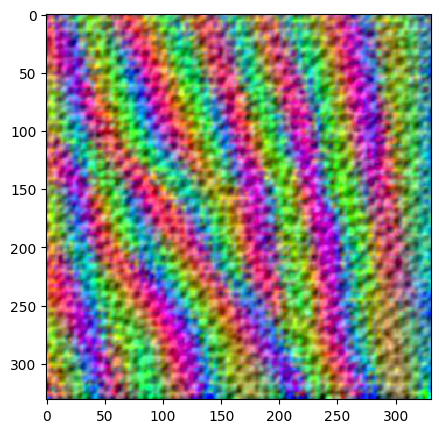

In [553]:
plt.rcParams['figure.figsize'] = [10, 5]
filter_pos = "444"
filter_num = 444

lt = 100
rt = 125
up = 75
dn = 100

lt = 0
rt = 332
up = 0
dn = 332

angle = 0
times = 1

image_g = plt.imread("/content/gdrive/My Drive/generated/final/green_f" + filter_pos + ".jpg")

image_g2 = np.zeros((331,331,3), dtype = np.uint8)
image_g2[lt:rt,up:dn,:] = image_g[lt:rt,up:dn,:]

g = layer_vis.get_activations(zoom(rotate(image_g2, angle), times), filter_num)

image_r = plt.imread("/content/gdrive/My Drive/generated/final/red_f" + filter_pos + ".jpg")

image_r2 = np.zeros((331,331,3), dtype = np.uint8)
image_r2[lt:rt,up:dn,:] = image_r[lt:rt,up:dn,:]

r = layer_vis.get_activations(zoom(rotate(image_r2, angle), times), filter_num)

image_b = plt.imread("/content/gdrive/My Drive/generated/final/blue_f" + filter_pos + ".jpg")

image_b2 = np.zeros((331,331,3), dtype = np.uint8)
image_b2[lt:rt,up:dn,:] = image_b[lt:rt,up:dn,:]

b = layer_vis.get_activations(zoom(rotate(image_b2, angle), times), filter_num)

image_a = plt.imread("/content/gdrive/My Drive/generated/final/all_f" + filter_pos + ".jpg")

image_a2 = np.zeros((331,331,3), dtype = np.uint8)
image_a2[lt:rt,up:dn,:] = image_a[lt:rt,up:dn,:]

a = layer_vis.get_activations(zoom(rotate(image_a2, angle), times), filter_num)
print(torch.max(r))
print(torch.max(g))
print(torch.max(b))
print(torch.max(a))
# a[0:2,:] = a[26:28,:] = a[:, 0:2] = a[:, 26:28] = 0
plt.imshow(zoom(rotate(image_a2, angle), times))

In [0]:
gray = np.uint8(np.stack((rgb2gray(image_a),)*3, axis=-1))
gray_a = layer_vis.get_activations(zoom(rotate(gray, angle), times), filter_num)

rand_im = np.uint8(np.random.uniform(100, 150, (331, 331, 3)))
rand_a = layer_vis.get_activations(zoom(rotate(rand_im, angle), times), filter_num)

white = np.ones((331, 331, 3), dtype=np.uint8) * 255
white_a = layer_vis.get_activations(zoom(rotate(white, angle), times), filter_num)

In [0]:
max_acts = [torch.max(rand_a).item(), torch.max(white_a).item(), torch.max(gray_a), torch.max(a).item(), torch.max(r).item(), torch.max(g).item(), torch.max(b).item()]
avg_acts = [torch.mean(rand_a).item(), torch.mean(white_a).item(), torch.mean(gray_a), torch.mean(a).item(), torch.mean(r).item(), torch.mean(g).item(), torch.mean(b).item()]

acts = {"max" : max_acts, "avg" : avg_acts}

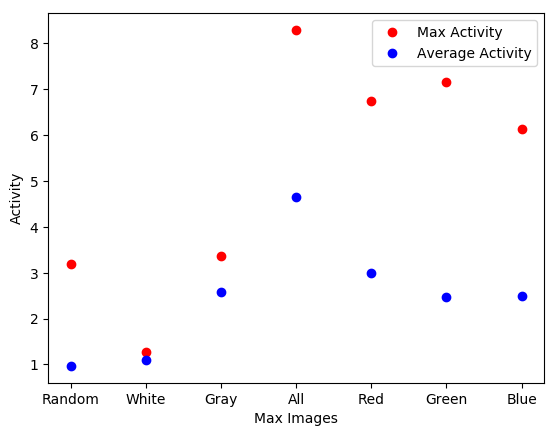

In [556]:
plt.style.use('default')
fig = plt.figure()

x = np.array([0,1,2,3,4, 5, 6])
y1 = acts["avg"]
y2 = acts["max"]
my_xticks = ['Random','White', 'Gray', 'All','Red','Green','Blue']
plt.xticks(x, my_xticks)
plt.plot(x, y2, "ro", y1, "bo")
plt.ylabel("Activity")
plt.xlabel("Max Images")
plt.legend(["Max Activity", "Average Activity"])
plt.show()
# im_path = '/content/gdrive/My Drive/generated/analysis/' + filter_pos + '/act_plot.jpg'
# plt.savefig(im_path)

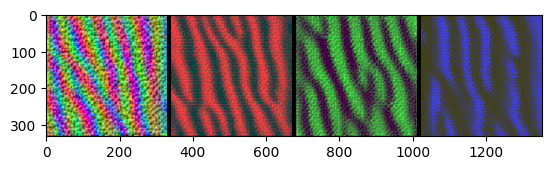

In [557]:
border = np.zeros((331, 10, 3), dtype = np.uint8)
image_all = np.concatenate((image_a, border, image_r, border, image_g, border, image_b), axis = 1)
plt.imshow(image_all)

im_path = '/content/gdrive/My Drive/generated/final/cat_f' + filter_pos + '.jpg'
save_image(image_all, im_path)

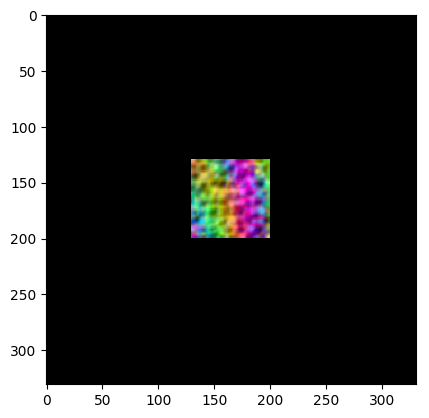

In [558]:
lt = 130
rt = 200
up = 130
dn = 200
image_a2 = np.zeros((331,331,3), dtype = np.uint8)
image_a2[lt:rt,up:dn,:] = image_a[lt:rt,up:dn,:]
plt.imshow(rotate(image_a2,0))
im_path = '/content/gdrive/My Drive/generated/final/center_f' + filter_pos + '.jpg'
save_image(image_a2, im_path)

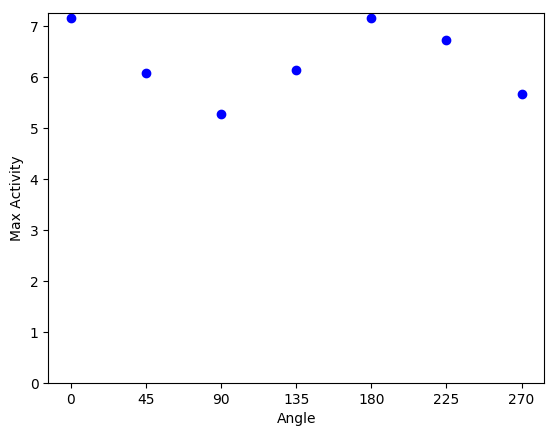

In [568]:
plt.rcParams['figure.figsize'] = [10, 5]
angles = [0, 45, 90, 135, 180, 225, 270]
a_top1 = [torch.max(layer_vis.get_activations(rotate(image_g, angle), filter_num)).item() for angle in angles]
plt.style.use('default')
fig = plt.figure()

plt.plot(angles, a_top1, "bo")
plt.ylabel("Max Activity")
plt.xlabel("Angle")
plt.xticks(np.arange(0, 271, 45))
plt.ylim(ymin=0)
plt.show()

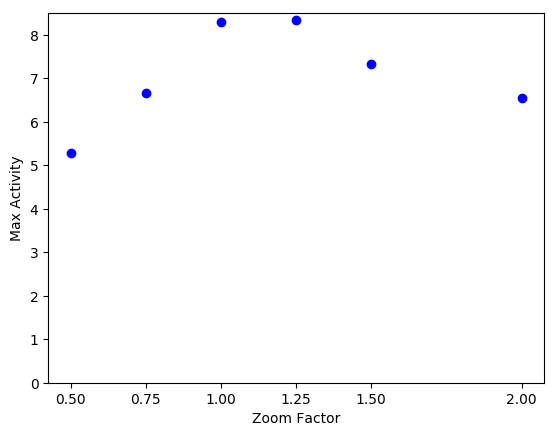

In [573]:
plt.rcParams['figure.figsize'] = [10, 5]
factors = [0.5, 0.75, 1, 1.25, 1.5, 2]
a_top1 = [torch.max(layer_vis.get_activations(zoom(image_a, factor), filter_num)).item() for factor in factors]
plt.style.use('default')
fig = plt.figure()

plt.plot(factors, a_top1, "bo")
plt.ylabel("Max Activity")
plt.xlabel("Zoom Factor")
plt.xticks([0.5, 0.75, 1, 1.25, 1.5, 2])
plt.ylim(ymin=0)
plt.show()

In [0]:
g_gf = image_g
g_bf = image_g[:,:,[0,2,1]]
g_rf = image_g[:,:,[1,0,2]]
g_grf = np.stack((g_gf[:,:,1],)*3, axis=-1)
# g_grf = np.uint8(np.stack((rgb2gray(g_gf),)*3, axis=-1))

g_g = layer_vis.get_activations(g_gf, filter_num)
g_b = layer_vis.get_activations(g_bf, filter_num)
g_r = layer_vis.get_activations(g_rf, filter_num)
g_gr = layer_vis.get_activations(g_grf, filter_num)

g_max_acts = [torch.max(g_gr).item(), torch.max(g_r).item(), torch.max(g_g).item(), torch.max(g_b).item()]
g_avg_acts = [torch.mean(g_gr).item(), torch.mean(g_r).item(), torch.mean(g_g).item(), torch.mean(g_b).item()]

g_acts = {"max" : g_max_acts, "avg" : g_avg_acts}

In [0]:
r_rf = image_r
r_gf = image_r[:,:,[1,0,2]]
r_bf = image_r[:,:,[2,1,0]]
r_grf = np.stack((r_rf[:,:,0],)*3, axis=-1)
# r_grf = np.uint8(np.stack((rgb2gray(r_rf),)*3, axis=-1))

r_g = layer_vis.get_activations(r_gf, filter_num)
r_b = layer_vis.get_activations(r_bf, filter_num)
r_r = layer_vis.get_activations(r_rf, filter_num)
r_gr = layer_vis.get_activations(r_grf, filter_num)

r_max_acts = [torch.max(r_gr).item(), torch.max(r_r).item(), torch.max(r_g).item(), torch.max(r_b).item()]
r_avg_acts = [torch.mean(r_gr).item(), torch.mean(r_r).item(), torch.mean(r_g).item(), torch.mean(r_b).item()]

r_acts = {"max" : r_max_acts, "avg" : r_avg_acts}

In [0]:
b_bf = image_b
b_rf = image_b[:,:,[2,1,0]]
b_gf = image_b[:,:,[0,2,1]]
b_grf = np.stack((b_bf[:,:,2],)*3, axis=-1)
# b_grf = np.uint8(np.stack((rgb2gray(b_bf),)*3, axis=-1))


b_g = layer_vis.get_activations(b_gf, filter_num)
b_b = layer_vis.get_activations(b_bf, filter_num)
b_r = layer_vis.get_activations(b_rf, filter_num)
b_gr = layer_vis.get_activations(b_grf, filter_num)

b_max_acts = [torch.max(b_gr).item(), torch.max(b_r).item(), torch.max(b_g).item(), torch.max(b_b).item()]
b_avg_acts = [torch.mean(b_gr).item(), torch.mean(b_r).item(), torch.mean(b_g).item(), torch.mean(b_b).item()]

b_acts = {"max" : b_max_acts, "avg" : b_avg_acts}

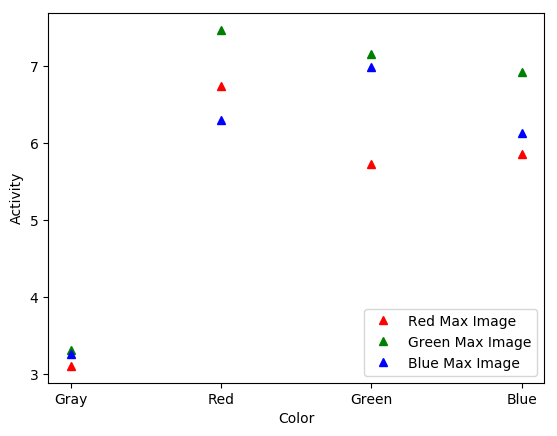

In [577]:
plt.style.use('default')
fig = plt.figure()

x = np.array([0,1,2,3])
my_xticks = ['Gray', 'Red','Green','Blue']
plt.xticks(x, my_xticks)

plt.plot(x, r_acts["max"], "r^", g_acts["max"], "g^",b_acts["max"], "b^")
# plt.plot(x, r_acts["max"], "r^", r_acts["avg"], "ro", g_acts["max"], "g^", g_acts["avg"], "go", b_acts["max"], "b^", b_acts["avg"], "bo")
plt.ylabel("Activity")
plt.xlabel("Color")
plt.legend(["Red Max Image", "Green Max Image", "Blue Max Image"])
plt.show()

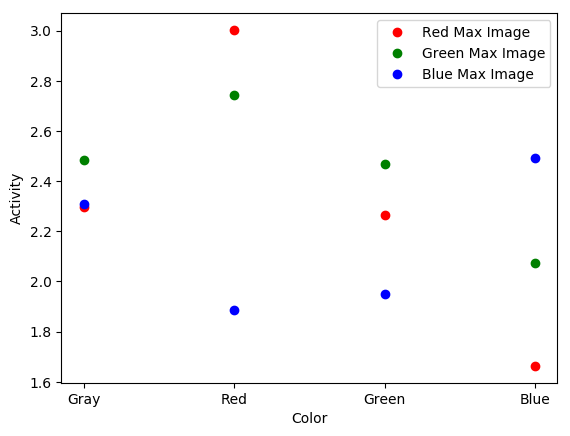

In [579]:
plt.style.use('default')
fig = plt.figure()

x = np.array([0,1,2,3])
my_xticks = ['Gray', 'Red','Green','Blue']
plt.xticks(x, my_xticks)

plt.plot(x, r_acts["avg"], "ro", g_acts["avg"], "go",b_acts["avg"], "bo")
# plt.plot(x, r_acts["max"], "r^", r_acts["avg"], "ro", g_acts["max"], "g^", g_acts["avg"], "go", b_acts["max"], "b^", b_acts["avg"], "bo")
plt.ylabel("Activity")
plt.xlabel("Color")
plt.legend(["Red Max Image", "Green Max Image", "Blue Max Image"])
plt.show()

8.287162780761719
-0.5847591161727905
4.638680458068848


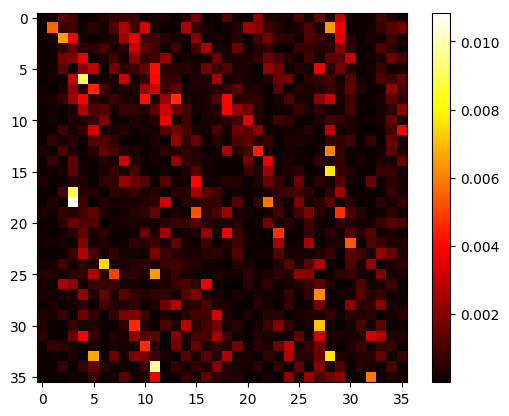

In [585]:
b = layer_vis.get_activations(zoom(image_a,1), layer_vis.selected_filter)
print(b.max().item())
print(b.min().item())
print(b.mean().item())
plt.imshow(torch.softmax(b[3:39,3:39].flatten(), dim = 0).reshape(36,36), cmap='hot')
# plt.imshow(a[3:39,3:39], cmap='hot')
# plt.imshow(a, cmap='hot')
plt.colorbar()
# plt.imshow(b, cmap='hot')""

3.5928432941436768
2.8968586921691895


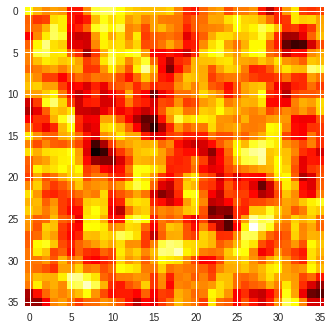

In [665]:
b = layer_vis.get_activations(zoom(im,1), layer_vis.selected_filter)
print(b.max().item())
print(b.mean().item())
plt.imshow(b[3:39,3:39], cmap='hot')

In [0]:
from scipy.ndimage import rotate

In [0]:
import cv2
def zoom(img, zoom_factor):
    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    Args:
        img : Image array
        zoom_factor : amount of zoom as a ratio (0 to Inf)
    """
    
    if zoom_factor == 1:
        return img
    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)

    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]

    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)

    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

Run the visualizer for each filter 

If all three channels needed, the last argument to CNNLayerVisualization can be left empty or set colors_to_remove to None.
[0,1] removes the R and G channels and gives blue